In [16]:
import sys
import numpy as np
import matplotlib.pyplot as plt

import torch, torchvision
import torchvision.transforms as T
from torch import nn
from torch import optim
# from torchvision.transforms import ToTensor
import torch.nn.functional as F

import sys
sys.path.append("./libs/ACDA")
import Conv_DCFD as acda

### LeNet
The LeNet network only has 2 layers. To see the effect of ACDA, the convolutional layers in the original LeNet were replaced with ACDA layers and the test results of the two models were compared.

Note: There were some problems with getting the unfold in ACDA implementation to work, so padding was needed for the layer to be created. All changes made to get the ACDA layer working were added back to the original LeNet so that they could have the same parameters for a better comparision between the two models.

Reference for LetNet implementation:
https://blog.paperspace.com/writing-lenet5-from-scratch-in-python/


In [17]:

class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super(LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(1024, 120)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

class LeNet5_ACDA(nn.Module):
    def __init__(self, num_classes):
        super(LeNet5_ACDA, self).__init__()
        self.layer1 = nn.Sequential(
            acda.Conv_DCFD(3, 6, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            acda.Conv_DCFD(6, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(1024, 120)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

leNet = LeNet5(num_classes=10)
leNet_acda = LeNet5_ACDA(num_classes=10)

criterion = nn.CrossEntropyLoss()
leNet_optimizer = optim.SGD(leNet.parameters(), lr=0.001, momentum=0.9)
leNet_acda_optimizer = optim.SGD(leNet_acda.parameters(), lr=0.001, momentum=0.9)

References for extracting and training on CIFAR-10 data:
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [18]:
# Train network
def train(model, optimizer, train_data, num_epochs=2):
    loss_vals = []
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(train_data, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                # print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                loss_vals.append(running_loss / 2000)
                running_loss = 0.0
    return loss_vals

def test(model, test_data):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in test_data:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    # print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')
    return 100 * correct // total


In [19]:
# Loading CIFAR-10 data
batch_size = 6

transform = T.Compose(
    [T.ToTensor(),
     T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


In [20]:
# LeNet
epochs = 5
running_loss = train(leNet, leNet_optimizer, trainloader, epochs)
test_results = test(leNet, testloader)

# LeNet + ACDA
running_loss_acda = train(leNet_acda, leNet_acda_optimizer, trainloader, epochs)
test_results_acda = test(leNet_acda, testloader)

In [21]:
leNet_params = sum(p.numel() for p in leNet.parameters() if p.requires_grad)
leNet_acda_params = sum(p.numel() for p in leNet_acda.parameters() if p.requires_grad)

print('LeNet:')
print(f'Accuracy on 1000 test images: {test_results} %, Number of parameters: {leNet_params}')

print('LeNet + ACDA')
print(f'Accuracy on 10000 test images: {test_results_acda} %, Number of parameters: {leNet_acda_params}')

LeNet:
Accuracy on 1000 test images: 63 %, Number of parameters: 136886
LeNet + ACDA
Accuracy on 10000 test images: 67 %, Number of parameters: 223664


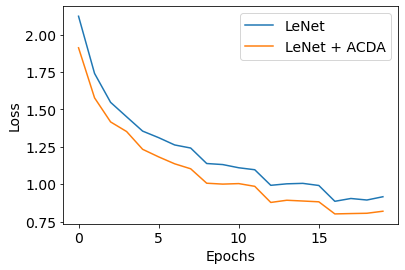

In [22]:
plt.rcParams.update({'font.size': 14})
plt.plot(range(len(running_loss)), running_loss, label='LeNet')
plt.plot(range(len(running_loss_acda)), running_loss_acda, label='LeNet + ACDA')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('./pix/img_classification_loss.pdf')
plt.show()